In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/vdubyna/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from tqdm import tqdm

In [3]:
train_dir = path + '/seg_train/seg_train'
test_dir = path + '/seg_test/seg_test'
# val_dir = path + '/seg_pred/seg_pred'

In [4]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
# val_loader = DataLoader(val_dataset, batch_size=32)

In [7]:
class_names = train_loader.dataset.classes
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
def imshow_grid(images, class_names, labels=None):
    images = images.numpy().transpose((1, 2, 0))  # C,H,W → H,W,C
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean  # зворотня нормалізація
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(12, 3))
    plt.imshow(images)
    if labels is not None:
        title = ", ".join([class_names[l] for l in labels])
        plt.title(title)
    plt.axis('off')
    plt.show()

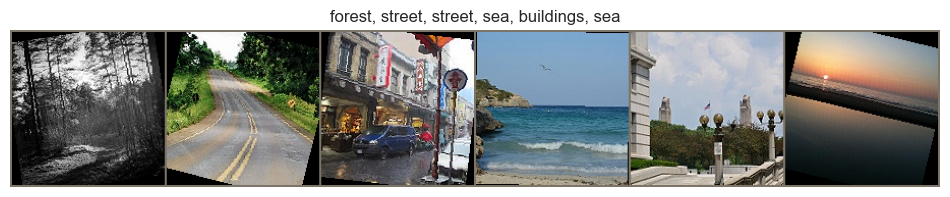

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

grid = make_grid(images[:6], nrow=6)
imshow_grid(grid, class_names, labels[:6])

In [10]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
# print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 6
Класи: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Розмір тренувального набору: 14034
Розмір тестового набору: 3000

Розподіл класів у тренувальному наборі:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=0.3)

        # Обчислити розмір вхідних даних для повнозв'язного шару
        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        # Прокинемо зображення через конволюційні шари, щоб дізнатися розмір
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [12]:
model = SimpleCNN(num_classes=6)

# Перенесення моделі на GPU, якщо доступно
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")
model = model.to(device)

Using MPS (Apple Silicon GPU)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Налаштування тренувального процесу
num_epochs = 8
best_test_loss = float('inf')
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [14]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), '../homeworks/best_model_1.pth')

100%|██████████| 439/439 [00:49<00:00,  8.90it/s]


Epoch 1/8:
Train Loss: 1.6647, Train Accuracy: 0.5711
Test Loss: 0.9065, Test Accuracy: 0.6673


100%|██████████| 439/439 [00:41<00:00, 10.69it/s]


Epoch 2/8:
Train Loss: 0.8667, Train Accuracy: 0.6813
Test Loss: 0.7122, Test Accuracy: 0.7513


100%|██████████| 439/439 [00:43<00:00, 10.15it/s]


Epoch 3/8:
Train Loss: 0.7706, Train Accuracy: 0.7215
Test Loss: 0.6843, Test Accuracy: 0.7413


100%|██████████| 439/439 [00:44<00:00,  9.82it/s]


Epoch 4/8:
Train Loss: 0.7030, Train Accuracy: 0.7488
Test Loss: 0.6083, Test Accuracy: 0.7937


100%|██████████| 439/439 [00:43<00:00, 10.11it/s]


Epoch 5/8:
Train Loss: 0.6692, Train Accuracy: 0.7646
Test Loss: 0.5618, Test Accuracy: 0.8103


100%|██████████| 439/439 [00:40<00:00, 10.87it/s]


Epoch 6/8:
Train Loss: 0.6284, Train Accuracy: 0.7713
Test Loss: 0.5974, Test Accuracy: 0.8033


100%|██████████| 439/439 [00:40<00:00, 10.91it/s]


Epoch 7/8:
Train Loss: 0.6027, Train Accuracy: 0.7866
Test Loss: 0.7692, Test Accuracy: 0.7680


100%|██████████| 439/439 [00:42<00:00, 10.23it/s]


Epoch 8/8:
Train Loss: 0.5839, Train Accuracy: 0.7909
Test Loss: 0.5164, Test Accuracy: 0.8243


In [15]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
model.load_state_dict(torch.load('../homeworks/best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.8757
F1 Score: 0.8754
[[388   3   2   2   1  41]
 [  0 469   1   3   1   0]
 [  1   4 468  58  19   3]
 [  2   5  90 404  20   4]
 [  3   2  28  19 457   1]
 [ 47   2   5   1   5 441]]


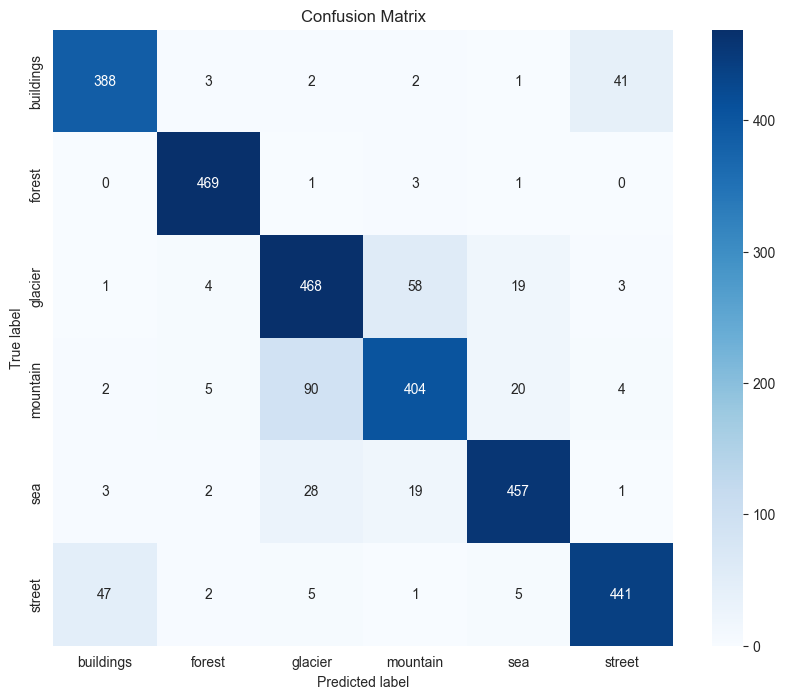

In [28]:
class_names = train_dataset.classes

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
print(cm)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

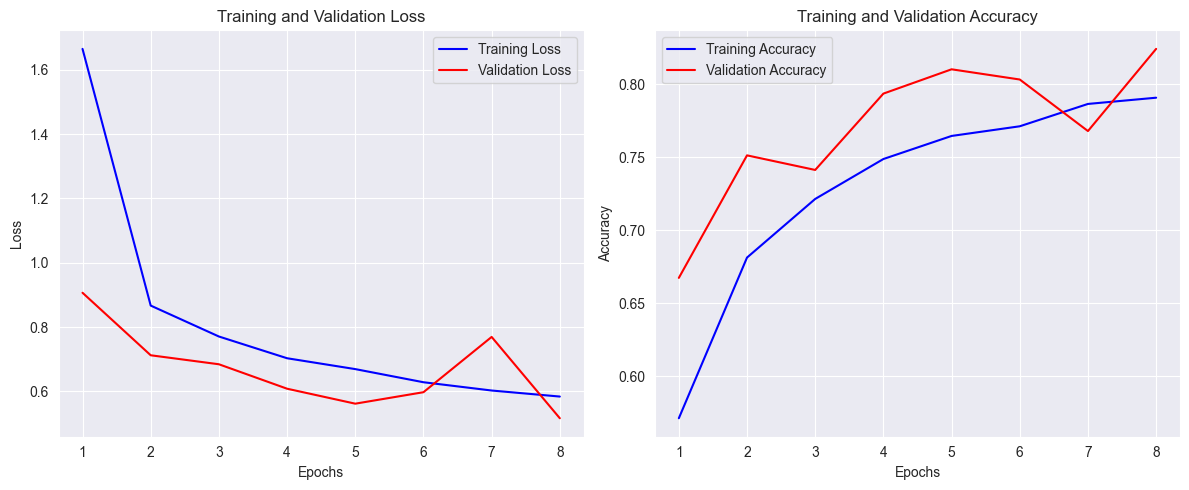

In [19]:
plot_training_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

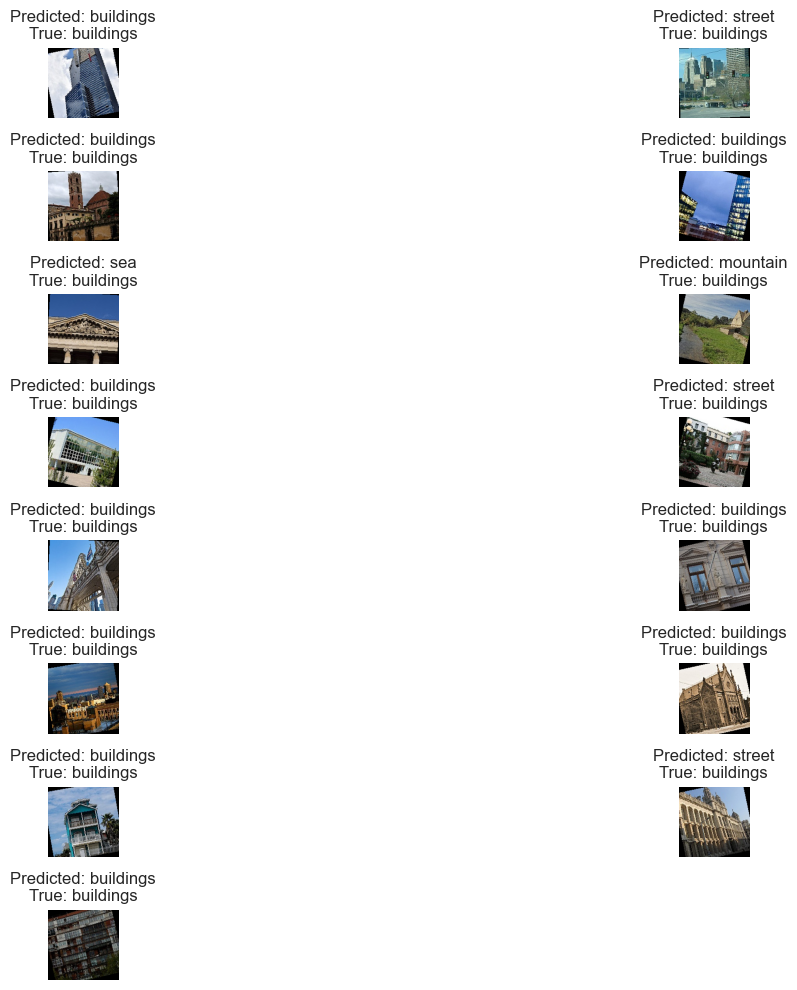

In [20]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)

In [48]:
from torchvision import models

# Завантажуємо попередньо навчену ResNet18
resnet_model = models.resnet18(weights='DEFAULT')

# Заморожуємо всі шари (щоб не переобучати)
for param in resnet_model.parameters():
    param.requires_grad = False

# Розморожуємо тільки останній блок
for name, param in resnet_model.layer4.named_parameters():
    if "1" in name:  # другий блок у layer4
        param.requires_grad = True

# Замінюємо останній повнозв'язний шар під наші 6 класів
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 6)

In [49]:
resnet_model = resnet_model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.0001)

trainable_params = filter(lambda p: p.requires_grad, resnet_model.parameters())
optimizer = optim.Adam(trainable_params, lr=1e-4)


In [50]:
num_epochs = 16
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Змінні для вчасної зупинки тренування
best_test_loss = float('inf')
patience = 3
patience_counter = 0

best_test_loss = float('inf')

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Валідація
    resnet_model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(resnet_model.state_dict(), '../homeworks/best_resnet_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"❗ No improvement in test_loss. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

Epoch 1/16, Train Acc: 0.8738, Test Acc: 0.9150
Epoch 2/16, Train Acc: 0.9220, Test Acc: 0.9157
❗ No improvement in val_loss. Patience: 1/3
Epoch 3/16, Train Acc: 0.9389, Test Acc: 0.9247
Epoch 4/16, Train Acc: 0.9519, Test Acc: 0.9200
Epoch 5/16, Train Acc: 0.9604, Test Acc: 0.9227
❗ No improvement in val_loss. Patience: 1/3
Epoch 6/16, Train Acc: 0.9675, Test Acc: 0.9227
❗ No improvement in val_loss. Patience: 2/3
Epoch 7/16, Train Acc: 0.9719, Test Acc: 0.9170
❗ No improvement in val_loss. Patience: 3/3
🛑 Early stopping triggered.


Test Accuracy: 0.9223
F1 Score: 0.9224
[[412   0   0   1   4  20]
 [  1 467   5   1   0   0]
 [  2   2 468  69  11   1]
 [  3   1  36 475  10   0]
 [  2   0  11  12 484   1]
 [ 34   1   1   2   2 461]]


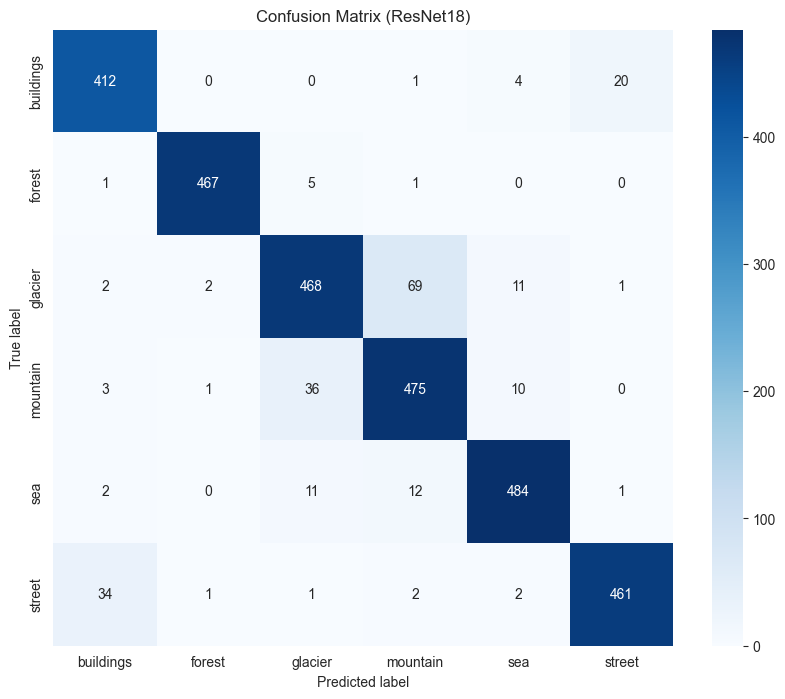

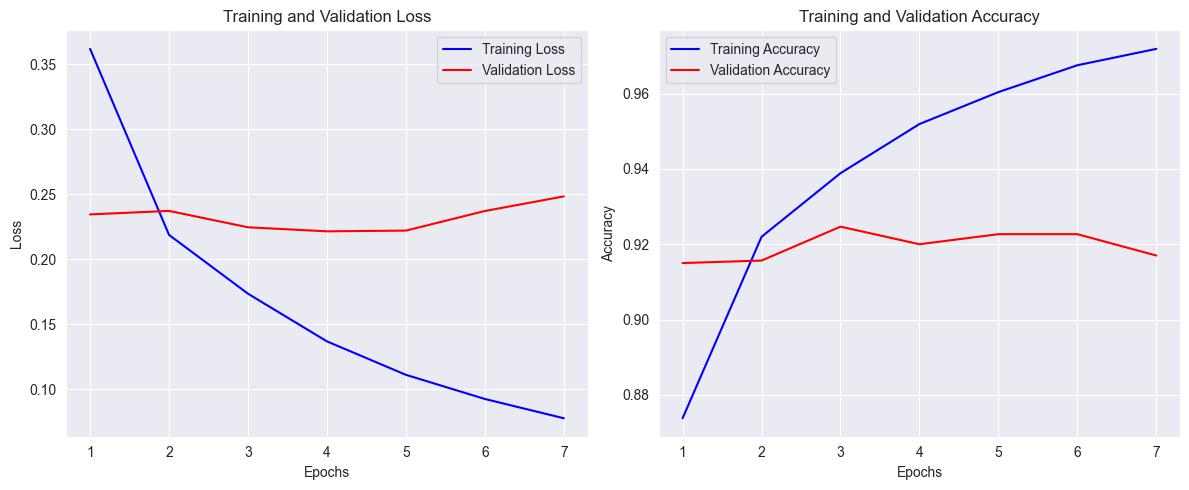

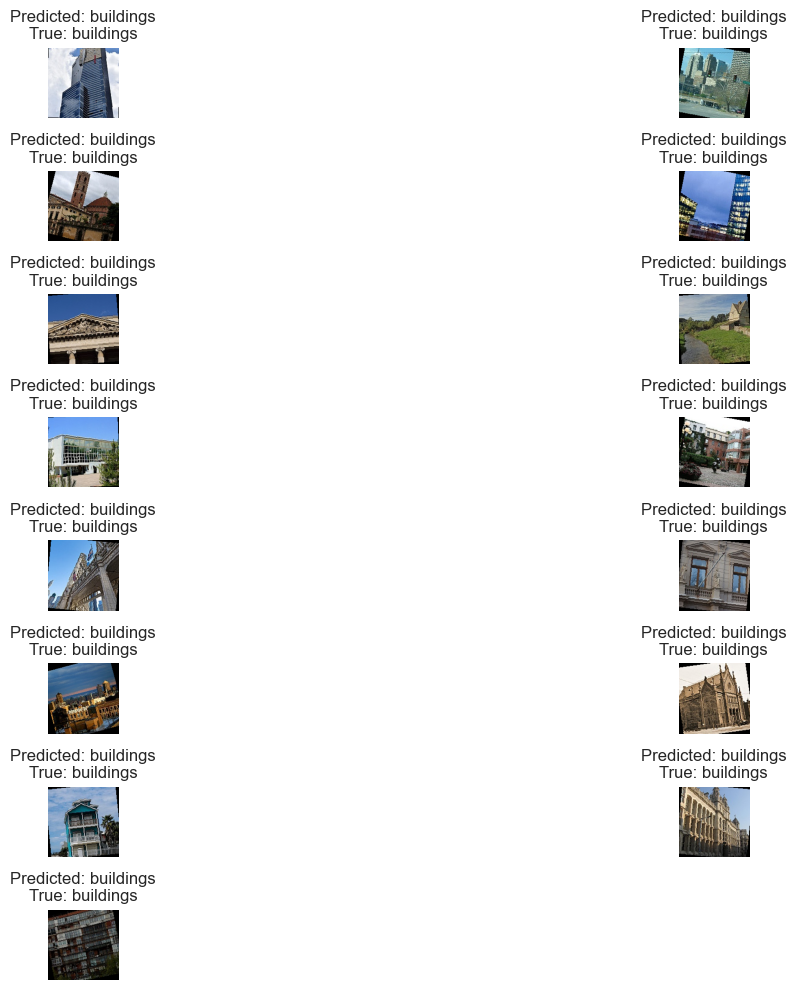

In [51]:
# 1. Підготовка
class_names = train_dataset.classes

# 2. Створення моделі і завантаження ваг
resnet_model = models.resnet18(weights='DEFAULT')
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 6)
resnet_model.load_state_dict(torch.load('../homeworks/best_resnet_model.pth'))
resnet_model = resnet_model.to(device)
resnet_model.eval()

# 3. Оцінка моделі на тестовому наборі
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Метрики
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# 5. Матриця помилок
cm = confusion_matrix(all_labels, all_preds)
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (ResNet18)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 6. Графіки навчання ResNet (якщо ти збирав ці метрики)
plot_training_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

# 7. Візуалізація передбачень
visualize_predictions(resnet_model, test_loader, class_names, num_images=15)


### Загальні висновки

#### Висновки щодо простої CNN-моделі

Ефективність:
  * Test Accuracy: 87.57%
  * F1 Score: 87.54%

Зауваження:
  * переплутування між деякими класами суттєве — особливо видно по матриці помилок.
  * спочатку я робив запуски без augumentation і через це модель дуже швидко перенавчалась
  * додавання `transforms.RandomRotation(degrees=(-15, 15)),` додало стійкості моделі і дозаолило вийти на хороші показники 87%

#### Висновки щодо використання Resnet18 моделі

Ефективність:
  * Test Accuracy: 0.9223
  * F1 Score: 0.9224

Зауваження:
  * Комбінація часткової розморозки + early stopping показало найкращі результати однак модель все ще схильна до перенавчання
    * При заморожуванні всіх шарів модель ледь досягала 87%
  * Довелося зменшити learning rate щоб дати можливість моделі адаптуватись до нових даних і не йти в перенавчання одразу
  * Думаю цю модель можна покращити додавши більше варіативності до даних використовуючи augumentation.
  * Також можливо варто ще зменшити learning rate